In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import pickle
import numpy as np

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import datasets, models, transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [3]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

In [4]:
# Пока не используем, нужно мухлевать с входными файлами данных
#import torch.nn.functional as F
# квадратизация (рисайз с паддингом, чтоб не было искажений по типу круг-овал) {будем вставлять в Compose}
#class SquarePad:
#    def __call__(self, image):
#        img = Image.open(image)
#        .decode_jpeg(img, channels = 3)
#        w, h = image.size
        
#        max_wh = np.max([w, h])
#        hp = int((max_wh - w) / 2)
#        vp = int((max_wh - h) / 2)
#        padding = (hp, vp, hp, vp)
#        return F.pad(img, padding, 0, 'constant')

In [5]:
# используем враппер над датасетом для удобной работы

class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
       # transform = transforms.Compose([
       #     transforms.ToTensor(),
       #     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
       # ])
        if self.mode == 'train' or self.mode =='val':
            transform = transforms.Compose([
                 transforms.RandomResizedCrop(224),
                 transforms.RandomHorizontalFlip(),
                 transforms.ToTensor(),
                 transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                 ])
        else:
            transform = transforms.Compose([
                transforms.Resize(224),
                #transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ])
        
        
        x = self.load_sample(self.files[index])
        #x = self._prepare_sample(x)
        #x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [6]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [7]:
TRAIN_DIR = Path('journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [8]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [9]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [10]:
val_dataset

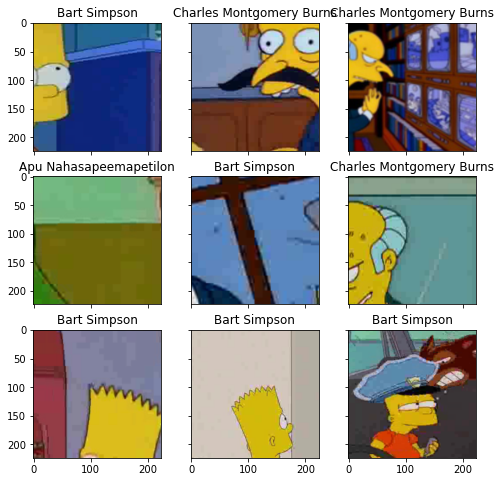

In [11]:
# Посмотрим на наших героев внутри датасета.

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

### Построение нейросети

*Описание слоев*:
1. размерность входа: 3x224x224 
2. размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [12]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [13]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [14]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [15]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [16]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [17]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv5): Sequential(
    (0): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=2400, out_fea

####  Обучение

In [18]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [19]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=5, batch_size=64)

epoch:   0%|                                                                                     | 0/5 [00:00<?, ?it/s]

loss 2.918723172993863


epoch:  20%|███████████████▍                                                             | 1/5 [01:17<05:09, 77.45s/it]


Epoch 001 train_loss: 2.9187     val_loss 2.6250 train_acc 0.1741 val_acc 0.2726
loss 2.449078928369558


epoch:  40%|██████████████████████████████▊                                              | 2/5 [02:34<03:52, 77.38s/it]


Epoch 002 train_loss: 2.4491     val_loss 2.2733 train_acc 0.3321 val_acc 0.3806
loss 2.1013352785059447


epoch:  60%|██████████████████████████████████████████████▏                              | 3/5 [03:52<02:35, 77.53s/it]


Epoch 003 train_loss: 2.1013     val_loss 1.9636 train_acc 0.4303 val_acc 0.4629
loss 1.828799740775648


epoch:  80%|█████████████████████████████████████████████████████████████▌               | 4/5 [05:09<01:17, 77.49s/it]


Epoch 004 train_loss: 1.8288     val_loss 1.7229 train_acc 0.5061 val_acc 0.5386
loss 1.628151781840403


epoch: 100%|█████████████████████████████████████████████████████████████████████████████| 5/5 [06:26<00:00, 77.33s/it]


Epoch 005 train_loss: 1.6282     val_loss 1.6679 train_acc 0.5537 val_acc 0.5545


In [20]:
loss, acc, val_loss, val_acc = zip(*history)

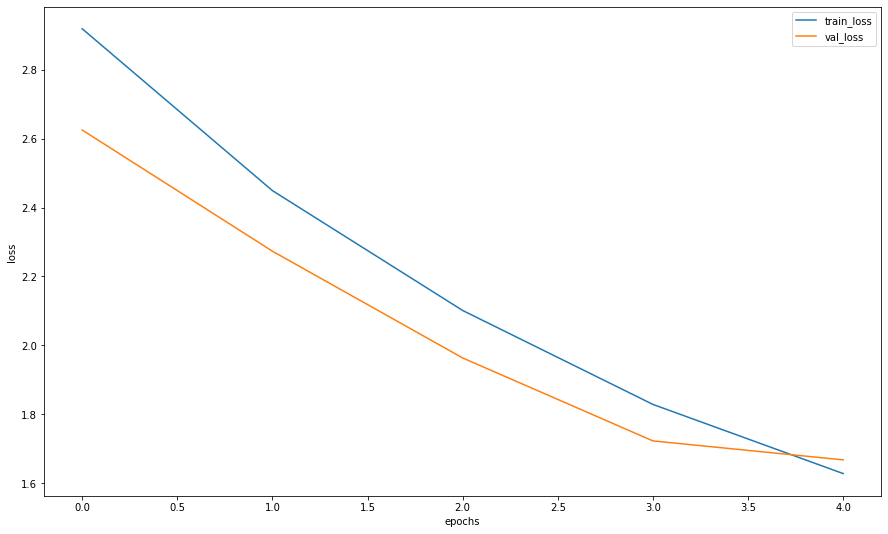

In [21]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

#### Подготовка на маленькой сети (AlexNet)

In [22]:
model_AlexNet = models.alexnet(pretrained=True)

In [23]:
model_AlexNet

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

* **Fine Tuning** способ

In [24]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 9216
# Заменяем Fully-Connected слой на наш линейный классификатор
model_AlexNet.classifier = nn.Linear(num_features, n_classes)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [25]:
model_AlexNet = model_AlexNet.to(DEVICE)

In [26]:
history = train(train_dataset, val_dataset, model=model_AlexNet, epochs=30, batch_size=64)

epoch:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

loss 2.666288210431575


epoch:   3%|██▌                                                                         | 1/30 [01:18<37:59, 78.60s/it]


Epoch 001 train_loss: 2.6663     val_loss 2.2674 train_acc 0.2556 val_acc 0.3880
loss 1.9223209473120726


epoch:   7%|█████                                                                       | 2/30 [02:37<36:38, 78.52s/it]


Epoch 002 train_loss: 1.9223     val_loss 1.7343 train_acc 0.4846 val_acc 0.5220
loss 1.6224824209351154


epoch:  10%|███████▌                                                                    | 3/30 [03:55<35:21, 78.58s/it]


Epoch 003 train_loss: 1.6225     val_loss 1.4601 train_acc 0.5697 val_acc 0.6146
loss 1.4266922932019226


epoch:  13%|██████████▏                                                                 | 4/30 [05:14<34:07, 78.76s/it]


Epoch 004 train_loss: 1.4267     val_loss 1.3733 train_acc 0.6232 val_acc 0.6408
loss 1.2849811840926062


epoch:  17%|████████████▋                                                               | 5/30 [06:33<32:45, 78.62s/it]


Epoch 005 train_loss: 1.2850     val_loss 1.2946 train_acc 0.6549 val_acc 0.6544
loss 1.2214054976369828


epoch:  20%|███████████████▏                                                            | 6/30 [07:51<31:25, 78.56s/it]


Epoch 006 train_loss: 1.2214     val_loss 1.1845 train_acc 0.6794 val_acc 0.6934
loss 1.212680431602639


epoch:  23%|█████████████████▋                                                          | 7/30 [09:09<30:05, 78.49s/it]


Epoch 007 train_loss: 1.2127     val_loss 1.1813 train_acc 0.6802 val_acc 0.6955
loss 1.13613675924553


epoch:  27%|████████████████████▎                                                       | 8/30 [10:28<28:46, 78.48s/it]


Epoch 008 train_loss: 1.1361     val_loss 1.1265 train_acc 0.7026 val_acc 0.7117
loss 1.1169255347500653


epoch:  30%|██████████████████████▊                                                     | 9/30 [11:46<27:27, 78.44s/it]


Epoch 009 train_loss: 1.1169     val_loss 1.1539 train_acc 0.7057 val_acc 0.7029
loss 1.1039247340750213


epoch:  33%|█████████████████████████                                                  | 10/30 [13:05<26:09, 78.46s/it]


Epoch 010 train_loss: 1.1039     val_loss 1.0845 train_acc 0.7139 val_acc 0.7224
loss 1.0744580593949875


epoch:  37%|███████████████████████████▍                                               | 11/30 [14:23<24:51, 78.48s/it]


Epoch 011 train_loss: 1.0745     val_loss 1.1689 train_acc 0.7167 val_acc 0.6968
loss 1.0440715533190073


epoch:  40%|██████████████████████████████                                             | 12/30 [15:42<23:32, 78.47s/it]


Epoch 012 train_loss: 1.0441     val_loss 1.0617 train_acc 0.7212 val_acc 0.7232
loss 1.0328614629372737


epoch:  43%|████████████████████████████████▌                                          | 13/30 [17:00<22:14, 78.51s/it]


Epoch 013 train_loss: 1.0329     val_loss 1.1124 train_acc 0.7288 val_acc 0.7163
loss 1.0175060960728466


epoch:  47%|███████████████████████████████████                                        | 14/30 [18:19<20:55, 78.50s/it]


Epoch 014 train_loss: 1.0175     val_loss 1.0617 train_acc 0.7328 val_acc 0.7287
loss 1.0449069610286863


epoch:  50%|█████████████████████████████████████▌                                     | 15/30 [19:37<19:37, 78.51s/it]


Epoch 015 train_loss: 1.0449     val_loss 1.0220 train_acc 0.7222 val_acc 0.7363
loss 1.0095366963410621


epoch:  53%|████████████████████████████████████████                                   | 16/30 [20:56<18:18, 78.49s/it]


Epoch 016 train_loss: 1.0095     val_loss 1.0760 train_acc 0.7342 val_acc 0.7312
loss 0.988763550028876


epoch:  57%|██████████████████████████████████████████▌                                | 17/30 [22:14<17:00, 78.50s/it]


Epoch 017 train_loss: 0.9888     val_loss 1.0469 train_acc 0.7392 val_acc 0.7279
loss 0.9863047786059368


epoch:  60%|█████████████████████████████████████████████                              | 18/30 [23:33<15:43, 78.60s/it]


Epoch 018 train_loss: 0.9863     val_loss 1.0742 train_acc 0.7445 val_acc 0.7344
loss 0.9897407445378179


epoch:  63%|███████████████████████████████████████████████▌                           | 19/30 [24:52<14:26, 78.81s/it]


Epoch 019 train_loss: 0.9897     val_loss 1.0290 train_acc 0.7379 val_acc 0.7367
loss 0.9935235390314456


epoch:  67%|██████████████████████████████████████████████████                         | 20/30 [26:12<13:10, 79.07s/it]


Epoch 020 train_loss: 0.9935     val_loss 1.0423 train_acc 0.7389 val_acc 0.7318
loss 0.9593078924885327


epoch:  70%|████████████████████████████████████████████████████▌                      | 21/30 [27:32<11:53, 79.24s/it]


Epoch 021 train_loss: 0.9593     val_loss 1.0238 train_acc 0.7481 val_acc 0.7425
loss 0.9794671545515273


epoch:  73%|██████████████████████████████████████████████████████▉                    | 22/30 [28:51<10:33, 79.22s/it]


Epoch 022 train_loss: 0.9795     val_loss 1.0362 train_acc 0.7455 val_acc 0.7386
loss 0.9732699226866832


epoch:  77%|█████████████████████████████████████████████████████████▌                 | 23/30 [30:09<09:13, 79.01s/it]


Epoch 023 train_loss: 0.9733     val_loss 1.0519 train_acc 0.7467 val_acc 0.7405
loss 0.9553151125740539


epoch:  80%|████████████████████████████████████████████████████████████               | 24/30 [31:28<07:53, 78.93s/it]


Epoch 024 train_loss: 0.9553     val_loss 0.9963 train_acc 0.7478 val_acc 0.7442
loss 0.9642722645195603


epoch:  83%|██████████████████████████████████████████████████████████████▌            | 25/30 [32:47<06:33, 78.80s/it]


Epoch 025 train_loss: 0.9643     val_loss 1.0340 train_acc 0.7482 val_acc 0.7415
loss 0.9562639435147532


epoch:  87%|█████████████████████████████████████████████████████████████████          | 26/30 [34:05<05:15, 78.77s/it]


Epoch 026 train_loss: 0.9563     val_loss 1.1389 train_acc 0.7510 val_acc 0.7285
loss 0.9796101150334098


epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 27/30 [35:24<03:56, 78.75s/it]


Epoch 027 train_loss: 0.9796     val_loss 1.0409 train_acc 0.7457 val_acc 0.7505
loss 0.9825784621082891


epoch:  93%|██████████████████████████████████████████████████████████████████████     | 28/30 [36:43<02:37, 78.68s/it]


Epoch 028 train_loss: 0.9826     val_loss 0.9983 train_acc 0.7469 val_acc 0.7467
loss 0.9253545655240769


epoch:  97%|████████████████████████████████████████████████████████████████████████▌  | 29/30 [38:01<01:18, 78.65s/it]


Epoch 029 train_loss: 0.9254     val_loss 0.9408 train_acc 0.7599 val_acc 0.7614
loss 0.9368341256876768


epoch: 100%|███████████████████████████████████████████████████████████████████████████| 30/30 [39:20<00:00, 78.68s/it]


Epoch 030 train_loss: 0.9368     val_loss 0.9909 train_acc 0.7522 val_acc 0.7553


In [27]:
loss, acc, val_loss, val_acc = zip(*history)

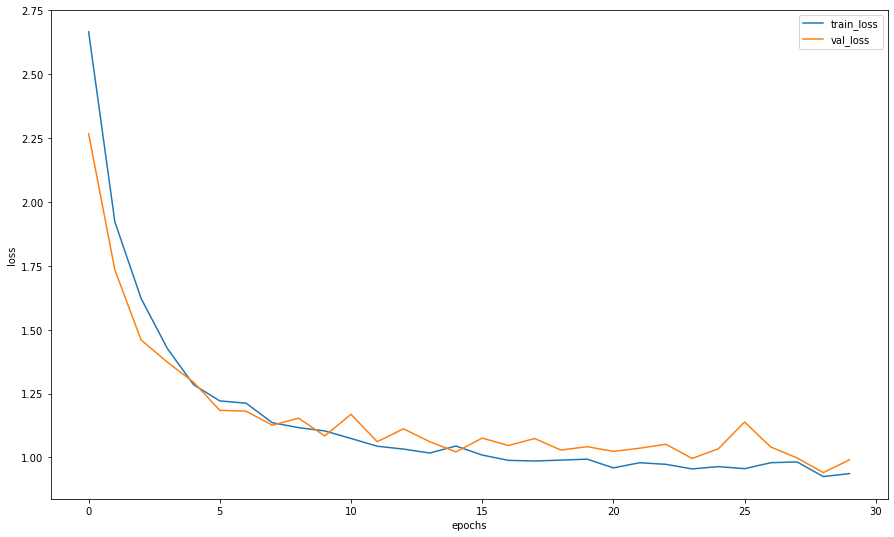

In [28]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [29]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [30]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(model_AlexNet, ex_img.unsqueeze(0))

In [31]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_AlexNet, imgs)

In [32]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [33]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [34]:
actual_labels

[4, 4, 0, 6, 3, 0, 5, 6, 0, 2, 6, 4, 0, 4, 0, 6, 6, 4, 4, 6]

In [35]:
preds_class

['comic_book_guy',
 'bart_simpson',
 'ned_flanders',
 'charles_montgomery_burns',
 'barney_gumble',
 'abraham_grampa_simpson',
 'moe_szyslak',
 'principal_skinner',
 'abraham_grampa_simpson',
 'apu_nahasapeemapetilon',
 'charles_montgomery_burns',
 'bart_simpson',
 'abraham_grampa_simpson',
 'bart_simpson',
 'abraham_grampa_simpson',
 'homer_simpson',
 'charles_montgomery_burns',
 'bart_simpson',
 'lisa_simpson',
 'charles_montgomery_burns']

In [36]:
y_pred

array([ 9,  4, 28,  6,  3,  0, 27, 32,  0,  2,  6,  4,  0,  4,  0, 15,  6,
        4, 20,  6], dtype=int64)

In [37]:
from sklearn.metrics import f1_score

#f1_score(actual_labels, preds_class)
f1_score(actual_labels, y_pred, average='micro')

0.7

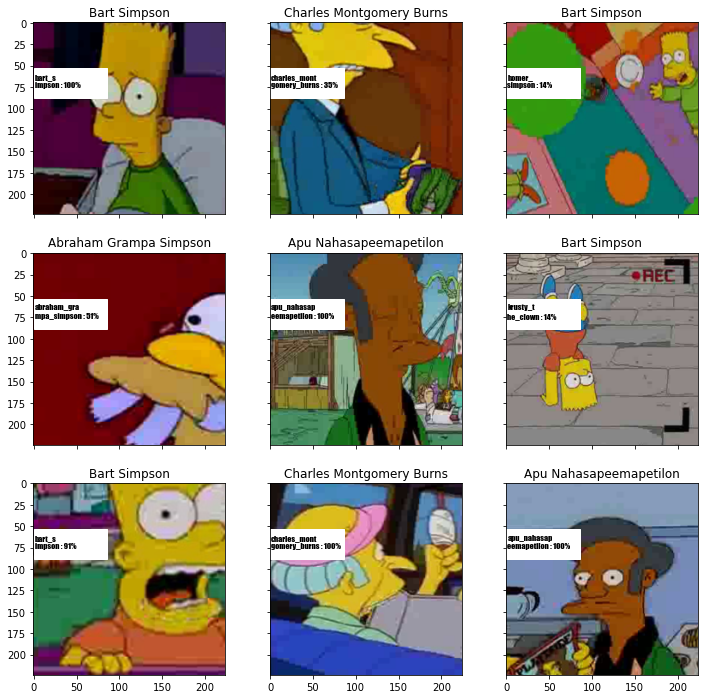

In [38]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(model_AlexNet, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

In [39]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_AlexNet, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

RuntimeError: stack expects each tensor to be equal size, but got [3, 252, 224] at entry 0 and [3, 334, 224] at entry 1

In [ ]:
len(preds)